## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep learning model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
!pip install tensorflow==2.12.0;
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight



drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**QUESTION:** Load dataset and display some lines of the csv file.

In [3]:
dataset_file = open("/content/drive/MyDrive/EMSE/Projet_IA_Embarquee/ai4i2020.csv")
dataset = dataset_file.readlines()

# display a few lines
for i in range(2, 6):
  print(dataset[i])

2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0

3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0

4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0

5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0



**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

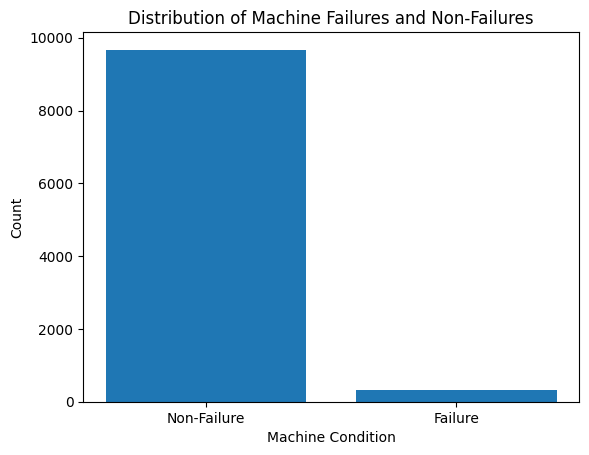

In [4]:
# Extract the relevant columns for failures
failure_columns = [line.split(',')[9:15] for line in dataset[1:]]

# Count the occurrences of failures and non-failures
failure_counts = [0, 0]
for row in failure_columns:
    if '1' in row:
        failure_counts[1] += 1
    else:
        failure_counts[0] += 1

# Plot the bar graph
plt.bar(['Non-Failure', 'Failure'], failure_counts)
plt.xlabel('Machine Condition')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On constate qu'il n'y à que peu de cas de Failure dans le dataset.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Avoir si peu d'exemples de cas de Failure risque de faire apprendre par coeur au modèles les données d'entrainement. Par conséquent le modèle ne pourra pas correctement généraliser sur les données et sera très bon à l'entrainement et mauvais en inférence (overfitting). Il faut construire le modèle en tenant en compte cette caractéristique du dataset.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

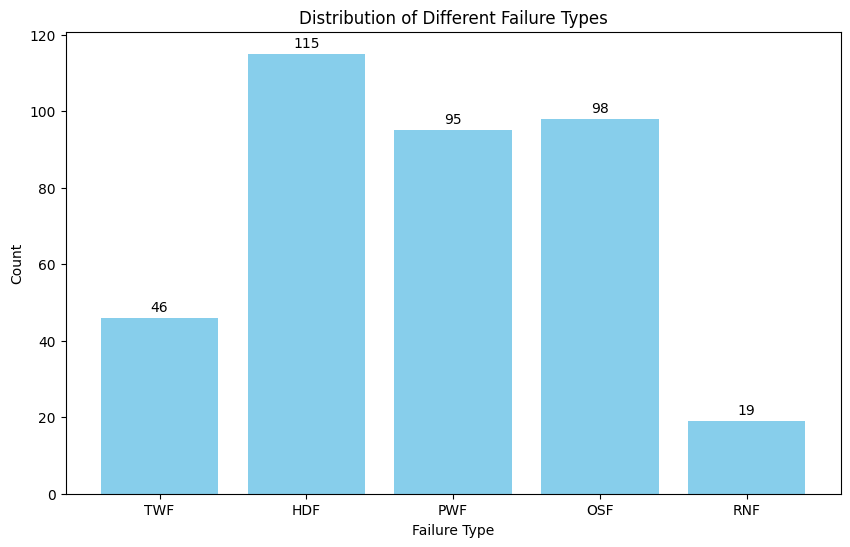

In [5]:
# Extract the relevant columns for each failure type
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = [0, 0, 0, 0, 0]

for row in dataset[1:]:
    columns = row.rstrip().split(',')
    for i in range(5):
        if columns[9 + i] == '1':
            failure_counts[i] += 1

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(failure_types, failure_counts, color='skyblue')

# Display the exact values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On constate que les Failures sont assez bien réparties entre les catégories. Les catégories HDF, PWF, OSF ont les plus de cas de Failure et sont équivalentes en termes de nombre de machines.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

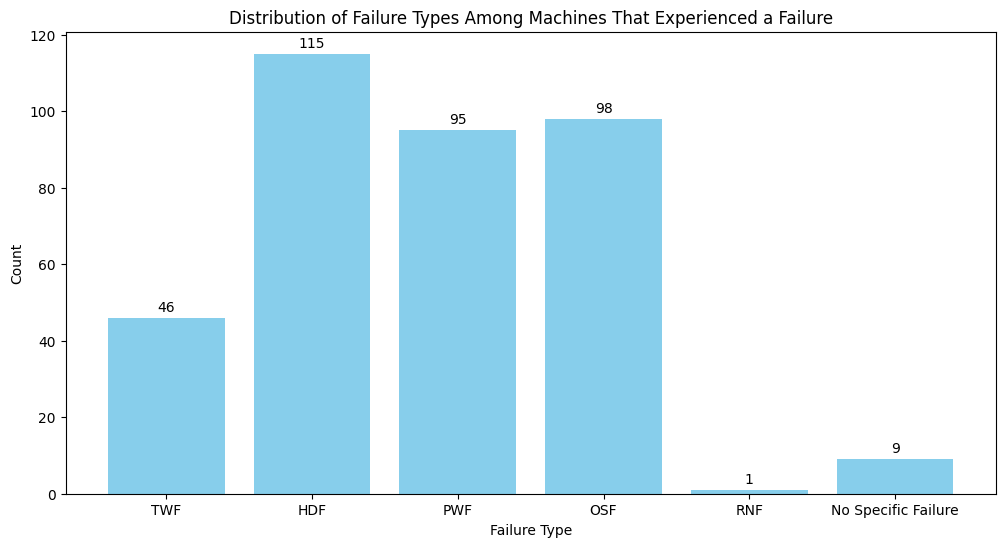

In [6]:
# Extract the relevant columns for each failure type and machine failure
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = [0, 0, 0, 0, 0]
no_specific_failure_count = 0

for row in dataset[1:]:
    columns = row.rstrip().split(',')
    if columns[8] == '1':  # Check if there is any machine failure
        specific_failures = sum([1 for i in range(5) if columns[9 + i] == '1'])
        if specific_failures == 0:
            no_specific_failure_count += 1
        else:
            for i in range(5):
                if columns[9 + i] == '1':
                    failure_counts[i] += 1

# Add the "No Specific Failure" category
failure_types.append("No Specific Failure")
failure_counts.append(no_specific_failure_count)

# Plot the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(failure_types, failure_counts, color='skyblue')

# Display the exact values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Machines That Experienced a Failure')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On constate qu'il n'y a qu'une seule Failure RNF qui a été détectée et classifiée. 9 autres ont été détectées mais pas classifiées. Enfin, 9 autres n'ont pas du tout été détectées. On peut en conclure qu'il est difficile de détecter les Failures de type RNF et qu'on ne pourra pas entrainer le modèle à les détecter (trop peu de données).

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [7]:
# Extract the header row
header = dataset[0].rstrip().split(',')

# Initialize a dictionary to store column names and their inferred data types
column_types = {col: 'Unknown' for col in header}

# Infer data types from the first data row
first_data_row = dataset[1].rstrip().split(',')

for i, value in enumerate(first_data_row):
    try:
        int(value)
        column_types[header[i]] = 'int'
    except ValueError:
        try:
            float(value)
            column_types[header[i]] = 'float'
        except ValueError:
            column_types[header[i]] = 'str'

# Display the column names and their inferred data types
for col, dtype in column_types.items():
    print(f'{col}: {dtype}')

﻿UDI: int
Product ID: str
Type: str
Air temperature [K]: float
Process temperature [K]: float
Rotational speed [rpm]: int
Torque [Nm]: float
Tool wear [min]: int
Machine failure: int
TWF: int
HDF: int
PWF: int
OSF: int
RNF: int


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to justify your response.

Inputs du modèle:
- Air temp
- Process temp
- Rotational speed
- Torque
- Tool wear

Outputs du modèle:
- TWF
- HDF
- PWF
- OSF
- NF (No failure)

Informations retirées des outpus:

* NRF: car on a trop peu de données pour pouvoir entrainer le modèle à prédire ce type de panne.
* NSF (No Specific Failure): On a pas d'information claire sur comment détecter ce type de panne. De plus on nous demande de détecter et classifier.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [8]:
# on cree les set de donnees pour le modele
X = []

for line in dataset[1:]:
  line_str = line.split(",")
  line_float = np.float64(line_str[3:])

  X.append(np.concatenate((line_float[0:5], [line_float[2] * line_float[3]])))


# X = [np.float64(line.split(",")[3:8]) for line in dataset[1:]]

Y = []
for line in dataset[1:]:
  if(sum(np.int64(line.split(",")[9:13])) == 0):
    Y.append(np.int64([0, 0, 0, 0, 1]))
  else:
    Y.append(np.int64(line.split(",")[9:13] + [0]))

# X : [<Air temp>, <Process temp>, <Rot speed>, <Torque>, <Tool wear>]
# Y : [<TWF>, <HDF>, <PWF>, <OSF>, <NF>] (NF pour No Faillure)

print(X[0:3])
print(Y[0:3])

[array([2.98100e+02, 3.08600e+02, 1.55100e+03, 4.28000e+01, 0.00000e+00,
       6.63828e+04]), array([2.98200e+02, 3.08700e+02, 1.40800e+03, 4.63000e+01, 3.00000e+00,
       6.51904e+04]), array([2.98100e+02, 3.08500e+02, 1.49800e+03, 4.94000e+01, 5.00000e+00,
       7.40012e+04])]
[array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 1])]


In [9]:
# POUR LA NORMALISATION
# from scipy.stats import zscore

# Normalize the values in X
X = np.array(X)
X = zscore(X, axis=0)

# CREATION DES DATASET TRAIN et TEST

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.60, random_state=42)

# Print the sizes of the resulting datasets
print(f"X_train size: {len(X_train)}")
print(f"y_train size: {len(Y_train)}")
print(f"X_test size: {len(X_test)}")
print(f"y_test size: {len(Y_test)}")

print(X_train[0:3])


X_train size: 4000
y_train size: 4000
X_test size: 6000
y_test size: 6000
[[-0.50242514 -0.94735989  1.08896253 -0.76109337  0.83343593 -0.37140209]
 [-0.95238944 -1.08216166 -0.57328699  0.67343468 -0.07778358  0.69600141]
 [ 0.4474995   0.5354596  -0.31669814 -0.2996368  -1.61743034 -0.50361586]]


**QUESTION** Code below the model architecture

In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 3,141
Trainable params: 3,141
Non-trainabl

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.5371 - accuracy: 0.9402 - val_loss: 0.2714 - val_accuracy: 0.9667
Epoch 2/50
125/125 [==============================] - 1s 4ms/step - loss: 0.2855 - accuracy: 0.9675 - val_loss: 0.2246 - val_accuracy: 0.9667
Epoch 3/50
125/125 [==============================] - 1s 4ms/step - loss: 0.2412 - accuracy: 0.9675 - val_loss: 0.1996 - val_accuracy: 0.9667
Epoch 4/50
125/125 [==============================] - 1s 4ms/step - loss: 0.2178 - accuracy: 0.9675 - val_loss: 0.1825 - val_accuracy: 0.9667
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.9675 - val_loss: 0.1698 - val_accuracy: 0.9667
Epoch 6/50
125/125 [==============================] - 0s 4ms/step - loss: 0.1930 - accuracy: 0.9675 - val_loss: 0.1585 - val_accuracy: 0.9667
Epoch 7/50
125/125 [==============================] - 0s 4ms/step - loss: 0.1913 - accuracy: 0.9675 - val_loss: 0.1498 - val_accuracy: 0.9667
Epoch 

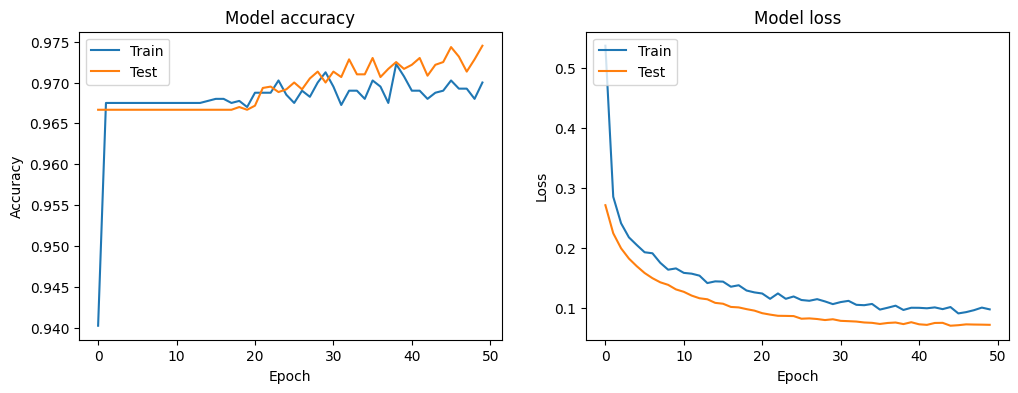

In [11]:
# Train the model
history = model.fit(X_train, np.array(Y_train), epochs=50, batch_size=32, validation_data=(X_test, np.array(Y_test)))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





188/188 [==============================] - 0s 988us/step
Classification Report:
               precision    recall  f1-score   support

         TWF       0.00      0.00      0.00        26
         HDF       1.00      0.17      0.29        70
         PWF       0.90      0.47      0.62        57
         OSF       0.55      0.36      0.44        47
          NF       0.98      1.00      0.99      5800

    accuracy                           0.97      6000
   macro avg       0.69      0.40      0.47      6000
weighted avg       0.97      0.97      0.97      6000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


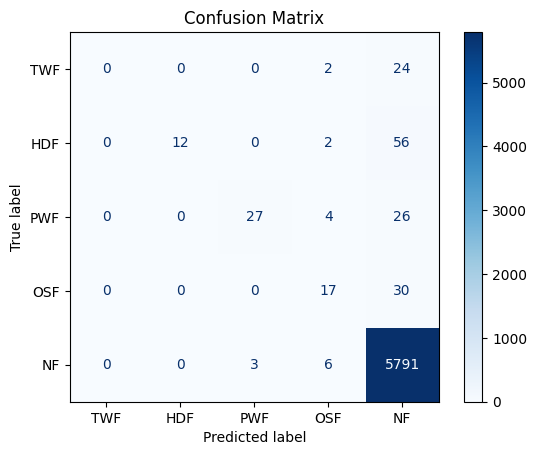

In [12]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=["TWF", "HDF", "PWF", "OSF", "NF"])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["TWF", "HDF", "PWF", "OSF", "NF"])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On observe que le modèle atteint une précision satisfaisante au vu de la matrice de confusion. En effet il y a très peu de valeurs hors diagonale et le cas le plus fréquent est le NF (Non Failure). On constate cependant qu'il y a un bon nombre d'erreurs de prédictions pour le cas NF.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr



**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [13]:
# from imblearn.over_sampling import SMOTE

# Filter out multiclass data from the training dataset
X_filtered = []
Y_filtered = []

for x, y in zip(X, Y):
    if sum(y) == 1 or sum(y) == 0:  # Keep only single class or no failure
        X_filtered.append(x)
        Y_filtered.append(y)

# Convert to numpy arrays
X_filtered = np.array(X_filtered)
Y_filtered = np.array(Y_filtered)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_resampled, Y_resampled = smote.fit_resample(X_filtered, Y_filtered)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.60, random_state=42)

# Print the sizes of the resampled datasets
print(f"X_train_resampled size: {len(X_resampled)}")
print(f"Y_train_resampled size: {len(Y_resampled)}")

X_train_resampled size: 48350
Y_train_resampled size: 48350


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [14]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                448       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 3,141
Trainable params: 3,141
Non-traina

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
605/605 [==============================] - 3s 3ms/step - loss: 13.4396 - accuracy: 0.5840 - val_loss: 1.4542 - val_accuracy: 0.7845
Epoch 2/50
605/605 [==============================] - 2s 3ms/step - loss: 4.2531 - accuracy: 0.7482 - val_loss: 1.4065 - val_accuracy: 0.7897
Epoch 3/50
605/605 [==============================] - 4s 6ms/step - loss: 2.7953 - accuracy: 0.7687 - val_loss: 1.2951 - val_accuracy: 0.7940
Epoch 4/50
605/605 [==============================] - 2s 4ms/step - loss: 2.2142 - accuracy: 0.7754 - val_loss: 1.2148 - val_accuracy: 0.7952
Epoch 5/50
605/605 [==============================] - 2s 4ms/step - loss: 1.9066 - accuracy: 0.7800 - val_loss: 1.1933 - val_accuracy: 0.7978
Epoch 6/50
605/605 [==============================] - 2s 4ms/step - loss: 1.6374 - accuracy: 0.7841 - val_loss: 1.1399 - val_accuracy: 0.7983
Epoch 7/50
605/605 [==============================] - 2s 3ms/step - loss: 1.5332 - accuracy: 0.7863 - val_loss: 1.0767 - val_accuracy: 0.7988
Epoch

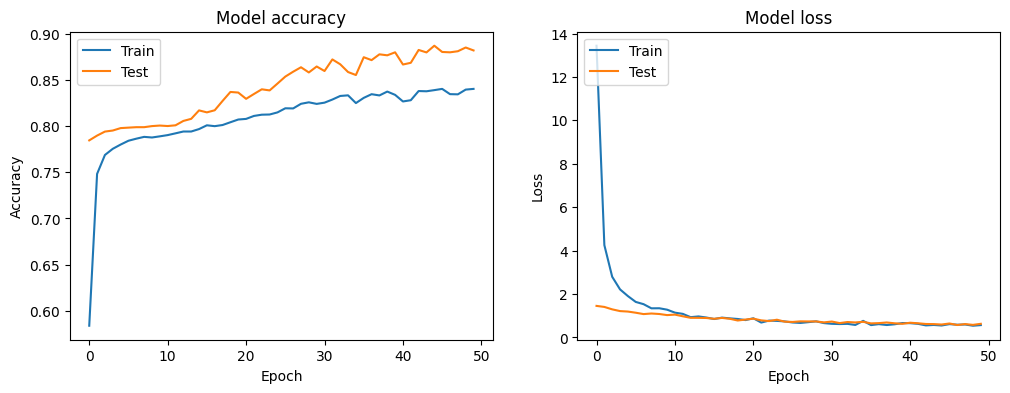

In [15]:
# from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_true_classes), y=y_true_classes)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
history = model.fit(X_train, np.array(Y_train), epochs=50, batch_size=32, validation_data=(X_test, np.array(Y_test)), class_weight=class_weights_dict)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

**QUESTION** Plot the confusion matrix and the classification report

907/907 [==============================] - 1s 991us/step
Classification Report:
               precision    recall  f1-score   support

         TWF       0.80      1.00      0.89      5766
         HDF       0.83      1.00      0.90      5721
         PWF       0.92      1.00      0.96      5874
         OSF       0.96      1.00      0.98      5839
          NF       1.00      0.41      0.58      5810

    accuracy                           0.88     29010
   macro avg       0.90      0.88      0.86     29010
weighted avg       0.90      0.88      0.86     29010



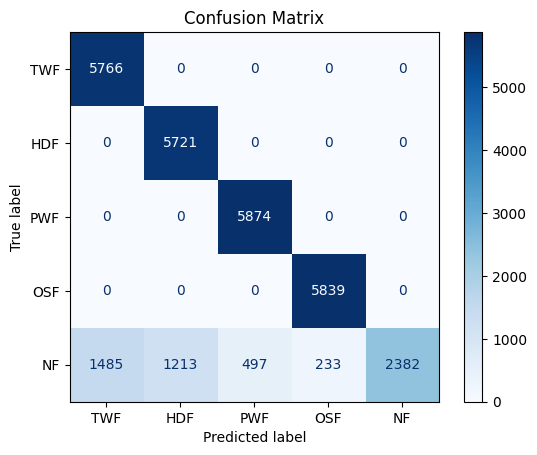

In [16]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=["TWF", "HDF", "PWF", "OSF", "NF"])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["TWF", "HDF", "PWF", "OSF", "NF"])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On en conclut que le jeu de données était effectivement trop petit pour correctement entrainer le modèle. La méthode d'oversampling associée à celle de pondération des classes faiblement représentées permet d'obtenir une bonne précision à l'entrainement et au test. La matrice de confusion montre que le modèle est précis pour classifier les pannes (valeurs regroupées sur la diagonale). On remarque que le modèle à tendance à prédire une panne alors qu'il n'y en a pas (valeurs non nulles sur la ligne du bas de la matrice de confusion). D'un point de vue industriel, il est préférable de prédire une fausse panne plutôt que de prédire une fausse abscence de panne (comme c'était le cas dans le test d'entrainement avec les données non augmentées).
L'entrainement est donc satisfaisant.


In [17]:
model.save("modele_prediction_panne.h5")
np.save("x_test.npy", np.float32(X_test))
np.save("y_test.npy", np.float32(Y_test))